# Multimodal Object Detection by Channel-Switching and Spatial Attention

**Directions for Use**: \
This notebook is self contained and was tested on a V100 High-Ram GPU on Google Colab. Simply run each cell sequentially, and the model will train using the hyperparameters given in the configuration dictionary a few cells down. 

**NOTE:** *At the end of this notebook are two cells meant to visualize the performance of your trained model*

In [ ]:
%pip install torch==1.13.1+cu117 torchvision==0.14.1+cu117 torchtext==0.14.1 torchaudio==0.13.1 torchdata==0.5.1 --extra-index-url https://download.pytorch.org/whl/cu117 -q
%pip install xmltodict -q
!pip install wandb --quiet
!pip install wget -q
%pip install torchinfo -q
%pip install torchmetrics -q

In [ ]:
import torch
import unittest
import random
from torchinfo import summary
import os
import torchvision
from torch.utils.data import Dataset, DataLoader
import numpy as np
import xmltodict
from PIL import Image
import tqdm
import wandb

import torchvision.transforms.functional as F
from PIL import ImageDraw
from PIL.ImageShow import IPythonViewer

In [ ]:
# set device usage
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"{DEVICE=}")

# Link to your drive if you are not using Colab with GCP
from google.colab import drive 
drive.mount('/content/drive')

DEVICE='cuda'


## Hyperparameters 

<b>*Notes & Context*</b> \
*Learning Rate, Epochs, and the CSSA switching threshold were all taken from the original work's methology. The reduction factor and channel sizes are the for establishing architecture of ResNet-50. One can choose to change these, however the pretrained weights on ImageNet will not longer be applicable and therefore a reduction in performance may be seen.* 

*The two gamme terms are used on the loss to regularize the loss over the bounding boxes to hopefully crease losses on the same scale, however this ultimately did not seem to change much.* 

In [ ]:
config = {
    'lr': 2.5e-4,
    'num_classes': 2, # classes + bg
    'reduction_factor': 4, # official reduction size for ResNet-50 in bottleneck block
    'cssa_switching_thresh': 2e-3,
    'fpn_feature_dim': 256,
    'channel_sizes': [256, 512, 1024, 2048],
    'batch_size': 3,
    'epochs': 10,
    'rpn_gamma': 10, # scaling factor for bbox regression loss
    'fcnn_gamma': 10,
    'checkpoints_path': '[fill-me-in]', # where to save training checkpoints
    'best_mAP': 0,
    'run_name': '[fill-me-in]'
    }

## Dataset Download & Dataloader

The LLVIP dataset can be found [here](https://github.com/bupt-ai-cz/LLVIP), and the download links for the dataset themselves can be found [here](https://github.com/bupt-ai-cz/LLVIP/blob/main/download_dataset.md). The intended use is on a cloud instance. Simply copying from your Google Drive account yielded the easiest results.

In [ ]:
!cp [fill-me-in] [fill-me-in]
!unzip -q 'LLVIP.zip' -d '/content/data'

In [85]:
class LLVIPDataset(Dataset):
    def __init__(self, root, rgb_mean=None, rgb_std=None, ir_mean=None, ir_std=None, partition="train", val_set={}, split=0.9, flips=True):

        self.partition = "train"
        self.flips = flips

        rgb_dir = os.path.join( root + "visible/" + partition + "/")
        ir_dir = os.path.join( root + "infrared/" + partition + "/")

        if partition == "valid" and val_set:

            rgb_paths = val_set["rgb"]
            ir_paths = val_set["ir"]

        elif partition == "valid" and not val_set:
            raise ValueError("Cannot make validation set without val_set arg!")

        else:

            rgb_paths = [os.path.join(rgb_dir + file) for file in sorted(os.listdir(rgb_dir))]
            ir_paths = [os.path.join(ir_dir + file) for file in sorted(os.listdir(ir_dir))]

            split_idx = int(len(rgb_paths) * split)

            self.val_set = {}
            rgb_paths, self.val_set["rgb"] = rgb_paths[:split_idx], rgb_paths[split_idx:]
            ir_paths, self.val_set["ir"] = ir_paths[:split_idx], ir_paths[split_idx:]

        self.data = []
        self.new_size = (640, 512)
        if rgb_mean and rgb_std and ir_mean and ir_std:
          self.rgb_normalize = torchvision.transforms.Normalize(rgb_mean, rgb_std)
          self.ir_normalize = torchvision.transforms.Normalize(ir_mean, ir_std)
          self.normalize = True
        else:
          print("No normalization of the images!")
          self.normalize = False

        self.to_tensor = torchvision.transforms.ToTensor()

        self.orig_size = self.to_tensor(Image.open(rgb_paths[0])).size()[1:]
        assert self.orig_size == self.to_tensor(Image.open(ir_paths[0])).size()[1:]

        loading_bar = tqdm.tqdm(total=len(rgb_paths), desc=f"Building {partition} dataset")
        for rgb_file, ir_file in zip(rgb_paths, ir_paths):

            base = os.path.splitext(os.path.basename(rgb_file))[0]
            annotation_file = os.path.join(root + "Annotations/" + base + ".xml")

            bboxes = []
            classes = []

            with open(annotation_file, "r") as file:
                annotation_dict = xmltodict.parse(file.read())
                bboxes, classes = self.get_bboxes(annotation_dict["annotation"])
            file.close()

            if not bboxes and not classes:
                tqdm.tqdm.write(f"Skipping File {base}, with no annotations.")
                loading_bar.update()
                continue
            else:
                bboxes = torch.FloatTensor(bboxes)
                classes = torch.LongTensor(classes).type(torch.int64)

            self.data.append({
                "base": base,
                "rgb": rgb_file,
                "ir": ir_file,
                "bboxes": bboxes,
                "classes": classes,
            })

            loading_bar.update()

    def map_idx(self, idx, max, new_max, min=0, new_min=0):
        # Convert the old range into the new range
        return ((idx - min) * (new_max - new_min) / (max - min)) + new_min

    def get_bboxes(self, annotation):
        """

        From fasterrcnn training:

        During training, the model expects both the input tensors and targets (list of dictionary),
        containing:
        - boxes (``FloatTensor[N, 4]``): the ground-truth boxes in ``[x1, y1, x2, y2]`` format, with
          ``0 <= x1 < x2 <= W`` and ``0 <= y1 < y2 <= H``.
        - labels (Int64Tensor[N]): the class label for each ground-truth box

        Args:
            annotation (_type_): _description_

        Returns:
            _type_: _description_
        """

        bboxes, classes, = [], []

        if "object" not in annotation.keys():
            return bboxes, classes

        if type(annotation["object"]) == list:
            object_list = annotation["object"]
        else:
            object_list = [annotation["object"]]

        for bbox in object_list:

            bbox_coords = [
                int(bbox["bndbox"]["xmin"]),
                int(bbox["bndbox"]["ymin"]),
                int(bbox["bndbox"]["xmax"]),
                int(bbox["bndbox"]["ymax"])
            ]

            if(bbox_coords[0] == bbox_coords[2] or bbox_coords[1] == bbox_coords[3]):
              continue

            bboxes.append(bbox_coords)
            classes.append(1) # all class 1, a person

        return bboxes, classes

    def collate_fn(self, batch):

        rgb_imagelist = []
        ir_imagelist = []
        targets = []

        for data in batch:

            rgb_tensor = self.to_tensor(Image.open(data["rgb"]))
            ir_tensor = self.to_tensor(Image.open(data["ir"]))

            if self.normalize:
              rgb_tensor = self.rgb_normalize(rgb_tensor)
              ir_tensor = self.ir_normalize(ir_tensor)

            bboxes = data["bboxes"]
            classes = data["classes"]

            # choose to randomly flip tensors & their bbox
            if self.flips and np.random.rand() < 0.5:
              rgb_tensor = torchvision.transforms.functional.hflip(rgb_tensor)
              ir_tensor = torchvision.transforms.functional.hflip(ir_tensor)
              # shape N, 4 [xmin, ymin, xmax, ymax]
              # flipping a bbox is like subtracting the width of the image from the bbox, also new min is the old max val
              new_min = rgb_tensor.shape[2] - bboxes[:, 2]
              new_max = rgb_tensor.shape[2] - bboxes[:, 0]

              bboxes[:, 0] = new_min
              bboxes[:, 2] = new_max

            # map the bboxes to the correct sizes after resize
            targets.append({
                "boxes": bboxes.to(DEVICE),
                "labels": classes.to(DEVICE)
            })
            rgb_imagelist.append(rgb_tensor.to(DEVICE))
            ir_imagelist.append(ir_tensor.to(DEVICE))



        if self.partition == "train":
          return rgb_imagelist, ir_imagelist, targets
        else:
          return rgb_imagelist, ir_imagelist

    def __getitem__(self, ind):
        return self.data[ind]

    def __len__(self):
        return len(self.data)

### Generating the Dataloaders

During the course of our ablations we noticed a nonneglible increase in performance for some cases when the data was normalized. If you wish to normalize the data, uncomment out the mean and standard deviations which were taken over the entire dataset.

The original authors also choose to flip their data horizontally, however this typically degraded performance. This is a chosen parameter of the dataset

In [ ]:
ROOT = "/content/data/LLVIP/" # may need to change this

llvip_train_data = LLVIPDataset(
    root = ROOT,
    # rgb_mean=[0.2226, 0.2136, 0.1458],
    # rgb_std=[0.1941, 0.1942, 0.1872],
    # ir_mean=[0.3116, 0.3116, 0.3116],
    # ir_std=[0.1681, 0.1681, 0.1681],
    flips=True
)

llvip_val_data = LLVIPDataset(
    root = ROOT,
    val_set=llvip_train_data.val_set,
    partition="valid",
    # rgb_mean=[0.2226, 0.2136, 0.1458],
    # rgb_std=[0.1941, 0.1942, 0.1872],
    # ir_mean=[0.3116, 0.3116, 0.3116],
    # ir_std=[0.1681, 0.1681, 0.1681],
    flips=False
)

train_loader = DataLoader(
                llvip_train_data,
                batch_size=config["batch_size"],
                collate_fn=llvip_train_data.collate_fn,
                shuffle=True,
)
val_loader = DataLoader(
                llvip_val_data,
                batch_size=config["batch_size"],
                collate_fn=llvip_val_data.collate_fn,
                shuffle=False
)



### Data Normalization

During the course of our ablations we noticed a nonneglible increase in performance for some cases when the data was normalized. If you wish to normalize the data, uncomment out the mean and standard deviations which were taken over the entire dataset. This should already be done thus this code does not need to be executed, only if you would like to verify the above mean and std.

In [87]:
# # placeholders
# rgb_psum    = torch.tensor([0.0, 0.0, 0.0]).to(DEVICE)
# rgb_psum_sq = torch.tensor([0.0, 0.0, 0.0]).to(DEVICE)

# ir_psum    = torch.tensor([0.0, 0.0, 0.0]).to(DEVICE)
# ir_psum_sq = torch.tensor([0.0, 0.0, 0.0]).to(DEVICE)

# for rgb, ir, targets in train_loader:
#   rgb_single_item_shape = rgb[0].shape
#   print("Single RGB Item Shape: ", rgb_single_item_shape)
#   ir_single_item_shape = ir[0].shape
#   print("Single IR Item Shape: ", ir_single_item_shape)
#   print("Devices: ", rgb[0].device, ir[0].device)
#   break

# for rgb, ir, targets in tqdm.tqdm(train_loader):

#   # loop through images
#   # for inputs in tqdm(data):
#   rgb_psum    += rgb[0].sum(axis        = [1, 2])
#   rgb_psum_sq += (rgb[0] ** 2).sum(axis = [1, 2])

#   ir_psum    += ir[0].sum(axis        = [1, 2])
#   ir_psum_sq += (ir[0] ** 2).sum(axis = [1, 2])

# for rgb, ir, targets in tqdm.tqdm(val_loader):

#   # loop through images
#   # for inputs in tqdm(data):
#   rgb_psum    += rgb[0].sum(axis        = [1, 2])
#   rgb_psum_sq += (rgb[0] ** 2).sum(axis = [1, 2])

#   ir_psum    += ir[0].sum(axis        = [1, 2])
#   ir_psum_sq += (ir[0] ** 2).sum(axis = [1, 2])



# # pixel count
# count = len(train_loader) * rgb_single_item_shape[1] * rgb_single_item_shape[2]

# # mean and std
# rgb_total_mean = rgb_psum / count
# ir_total_mean = ir_psum / count

# rgb_total_var  = (rgb_psum_sq / count) - (rgb_total_mean ** 2)
# rgb_total_std  = torch.sqrt(rgb_total_var)

# ir_total_var  = (ir_psum_sq / count) - (ir_total_mean ** 2)
# ir_total_std  = torch.sqrt(ir_total_var)

# # output
# print('\n rgb mean: '  + str(rgb_total_mean))
# print(' rgb std:  '  + str(rgb_total_std))

# print('\n ir mean: '  + str(ir_total_mean))
# print(' ir std:  '  + str(ir_total_std))

### Dataset Visualization:

Running the below cells allows you to do the following things:
- Verify that the dataset holds the correct float values between 0-1 as is required by PyTorch Faster-RCNN Model
- Visualize and verify that bbox targets are over the correct area of the image
- Verify that the sizes are roughly the same and the modes are aligned

In [88]:
def stack_images(image1, image2):
    # Determine the maximum height among the two images
    max_height = max(image1.size[1], image2.size[1])

    # Create a new blank image with double the width of the input images and maximum height
    stacked_image = Image.new('RGB', (image1.size[0] + image2.size[0], max_height))

    # Paste the first image onto the blank image
    stacked_image.paste(image1, (0, 0))

    # Paste the second image next to the first one
    stacked_image.paste(image2, (image1.size[0], 0))

    return stacked_image

def visualize_bboxes(ind, rgb, ir, target, pred=None, _slice=False):

    rgb_image = F.to_pil_image(rgb[ind])
    rgb_draw = ImageDraw.Draw(rgb_image)

    ir_image = F.to_pil_image(ir[ind])
    ir_draw = ImageDraw.Draw(ir_image)

    img_slice = None
    for i, bbox in enumerate(target[ind]['boxes']):

        if not img_slice:
            img_slice = [int(idx) for idx in bbox]

        ir_draw.rectangle(list(bbox), outline=(0, 255, 0))
        rgb_draw.rectangle(list(bbox), outline=(0, 255, 0))

    if pred:
      for i, bbox in enumerate(pred[ind]['boxes']):

        if not img_slice:
            img_slice = [int(idx) for idx in bbox]

        ir_draw.rectangle(list(bbox), outline=(255, 0, 0))
        rgb_draw.rectangle(list(bbox), outline=(255, 0, 0))


    im_show = IPythonViewer()

    img = stack_images(rgb_image, ir_image)

    im_show.show(img)

    if _slice:
      rgb_image_slice = F.to_pil_image(rgb[ind][:, img_slice[1]:img_slice[3], img_slice[0]:img_slice[2] ])
      rgb_show_slice = IPythonViewer()
      rgb_show_slice.show(rgb_image_slice)


In [ ]:
for i, (rgb, ir, target) in enumerate(train_loader):

    print("DATA GENERAL INFO \n")
    print(f"Proper Values RGB: { 1.0 >= rgb[0].all() >= 0.0 } | Proper Values IR: { 1.0 >= ir[0].all() >= 0.0 }")
    print(75 * "+")
    print(f"\n{rgb[0].size()=} | {rgb[0].device}")
    print(f"{ir[0].size()=} |  {ir[0].device}")
    print(f"{target[0]=}\n")
    print(75*"=")

    visualize_bboxes(0, rgb, ir, target)

    break

## Pipeline

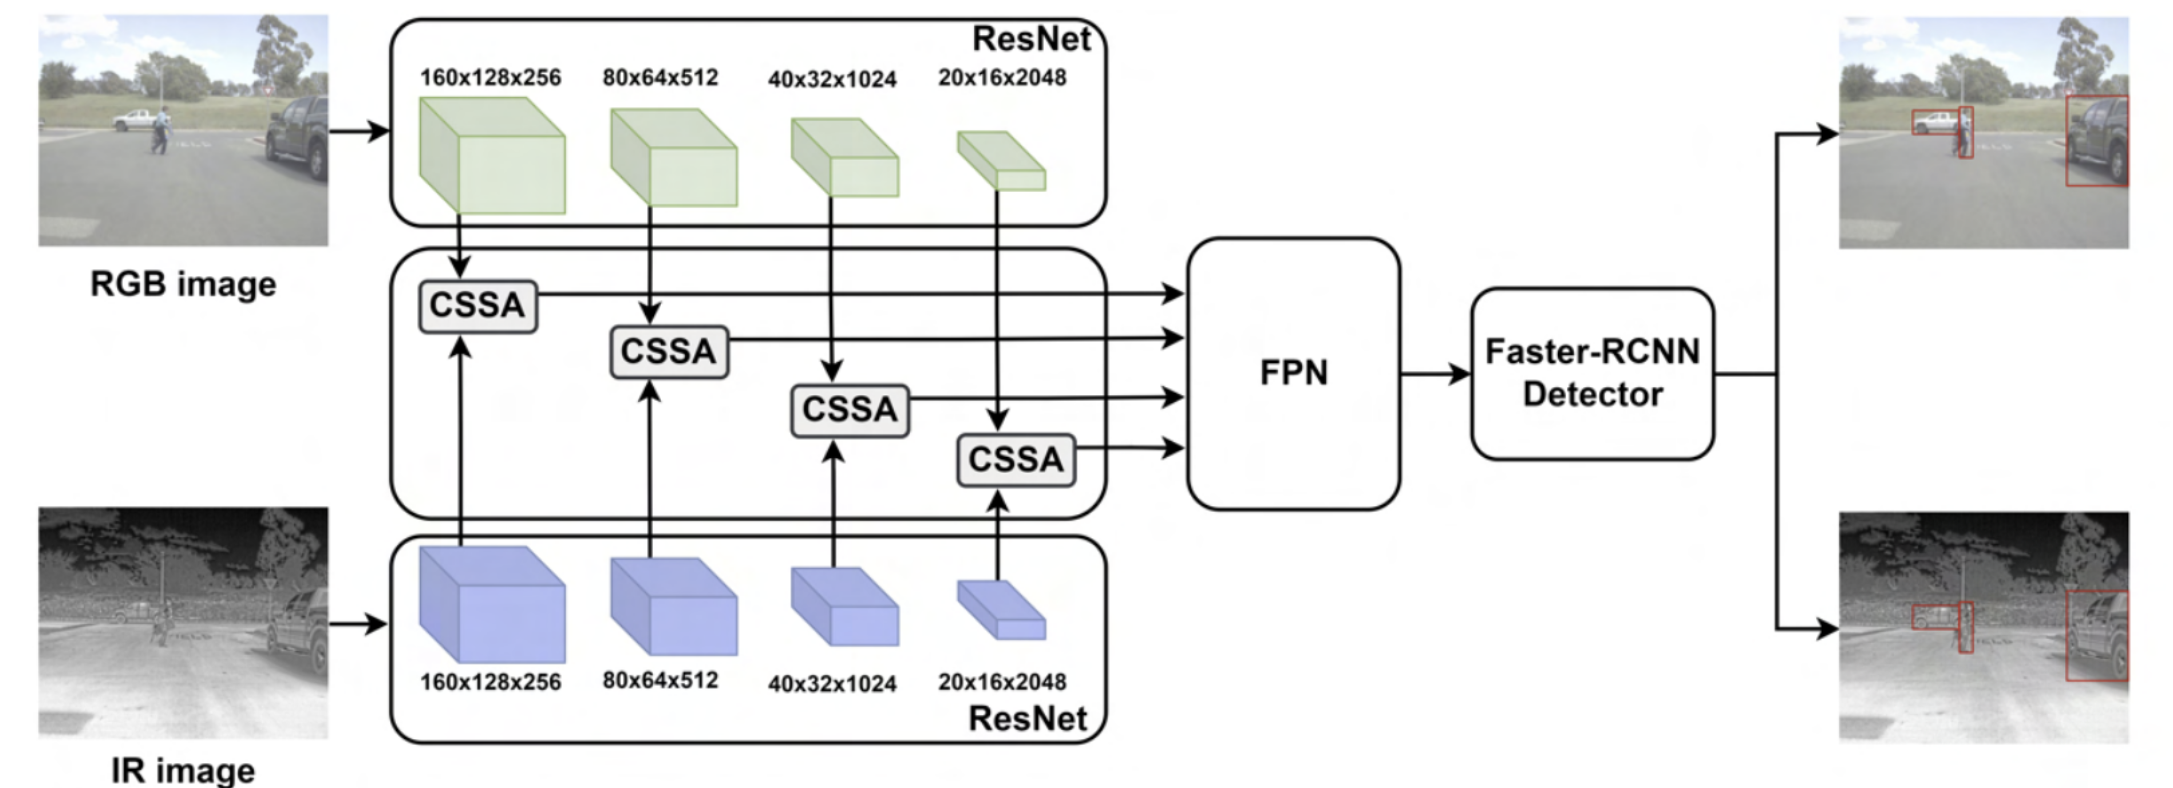

The following cells contain modules that can help to create the above architecture:
- **ResNetBottleneck**: custom ResNet module with bottleneck blocks capable of returning feature at various levels of the bacbone
- **ResNetStem**: custom ResNet stem 
- **ECA Block & Channel Switching**: custom ECA block meant to highlight important channels
- **Spatial Attention**: custom ECA block meant to highlight important spatial locations in image space
- **CSSA Block**: combines the above two blocks
- **Backbone**: combines all blocks above, also capable of using strictly PyTorch modules to accomplish this. The extra parameter `custom` informs the backbone whether to be constructed from our implementation or PyTorch official modules.
- **FPN:** Custom Feature pyramid which creates scale invariant features, does not include a final pooling layer as seen in other FPNs. 
- **FasterRCNN:** Modified version of PyTorch's implementation to allow for the inclusion of both an rgb and ir image into the backbone module. 

In [90]:
class ResNetBottleneck(torch.nn.Module):

    def __init__(self, in_channels, reduction_channels, out_channels, stride=1):
        super(ResNetBottleneck, self).__init__()

        # basic idea: reduce to inchannels to redunction channels, the back up to outchannels afterwards

        self.conv1x1_reduction = torch.nn.Conv2d(in_channels, reduction_channels, kernel_size=1, bias=False)
        self.bn1 = torch.nn.BatchNorm2d(reduction_channels)

        self.relu = torch.nn.ReLU(inplace=True)

        self.conv3x3_process = torch.nn.Conv2d(reduction_channels, reduction_channels, kernel_size=3, padding=1, stride=stride, bias=False)
        self.bn2 = torch.nn.BatchNorm2d(reduction_channels)

        self.conv1x1_expansion = torch.nn.Conv2d(reduction_channels, out_channels, kernel_size=1, bias=False)
        self.bn3 = torch.nn.BatchNorm2d(out_channels)

        self.downsample = None

        if in_channels != out_channels or stride > 1:
            self.downsample = torch.nn.Sequential(
                torch.nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                torch.nn.BatchNorm2d(out_channels)
            )


    def forward(self, x):
      x_in = x

      Fx = self.conv1x1_reduction(x)
      Fx = self.bn1(Fx)
      Fx = self.relu(Fx)

      Fx = self.conv3x3_process(Fx)
      Fx = self.bn2(Fx)
      Fx = self.relu(Fx)

      Fx = self.conv1x1_expansion(Fx)
      Fx = self.bn3(Fx)

      # if we have a stride > 1 in the first conv layer, we need to downsample
      # the input to have shapes match
      if self.downsample is not None:
        x_in = self.downsample(x)

      # approx the residual function
      Fx = Fx + x_in
      Fx = self.relu(Fx)

      return Fx



In [91]:
class ResNetStem(torch.nn.Module):
    # channels may also be termed as planes within the context of blocks
    def __init__(self, in_channels, out_channels, kernel_size=7, stride=2, padding=3, pool=3, pool_stride=2):
        super(ResNetStem, self).__init__()

        # the stem of a
        self.conv = torch.nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
        self.bn = torch.nn.BatchNorm2d(out_channels)
        self.relu = torch.nn.ReLU(inplace=True)
        self.pool = torch.nn.MaxPool2d(kernel_size=pool, stride=pool_stride, padding=1)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.pool(x)

        return x

In [92]:
from importlib.util import set_package
import gc
torch.cuda.empty_cache()
gc.collect()

class TresNetBottleneck(torch.nn.Module):

    # resnet uses either bottleneck or basic blocks

    def __init__(self, stem_in, blocks, reduction_factor, num_classes=7001):
        super(TresNetBottleneck, self).__init__()

        self.stem = ResNetStem(in_channels=stem_in, out_channels=blocks[0]//reduction_factor)

        self.stages = torch.nn.ModuleList()
        stage = []

        self.out_channels = config['fpn_feature_dim']

        for i in range(len(blocks)):

            prev_ch = blocks[0] // reduction_factor if i == 0 else blocks[i-1]
            curr_ch = blocks[i]
            next_ch = blocks[i] if i == len(blocks)-1 else blocks[i+1]

            if curr_ch != prev_ch:

              stride = 1 if curr_ch <= 256 else 2
              stage.append(ResNetBottleneck(in_channels=prev_ch, reduction_channels=(curr_ch // reduction_factor), out_channels=curr_ch, stride=stride))

            elif curr_ch != next_ch:
              stage.append(ResNetBottleneck(in_channels=curr_ch, reduction_channels=(curr_ch // reduction_factor), out_channels=curr_ch))

              self.stages.append(torch.nn.Sequential(*stage))
              stage = []

            else:
              stage.append(ResNetBottleneck(in_channels=curr_ch, reduction_channels=(curr_ch // reduction_factor), out_channels=next_ch))

        self.stages.append(torch.nn.Sequential(*stage))


        self.avgpool = torch.nn.AdaptiveAvgPool2d(1)
        self.flatten = torch.nn.Flatten()

        self.fc = torch.nn.Linear(blocks[-1], num_classes)

    def forward(self, x, return_feats=False):

        feat = self.stem(x)

        stage_features = []
        for i, stage in enumerate(self.stages):
          feat = stage(feat)

          if return_feats:
                stage_features.append(feat)

        x = self.fc(self.flatten(self.avgpool(feat)))

        if return_feats:
            return stage_features
        else:
            return x

    def get_weights(self, model):
        return [param for name, param in model.named_parameters() if "weight" in name and "bn" not in name]

    def get_biases(self, model):
        return [param for name, param in model.named_parameters() if "bias" in name and "bn" not in name]

    def get_batchnorms(self, model):
        weights = [param for name, param in model.named_parameters() if "bn" in name and "weight" in name]
        biases = [param for name, param in model.named_parameters() if "bn" in name and "bias" in name]
        return weights + biases

    def compare_model_components(self, model):
        # Compare Weights
        weights1 = self.get_weights(self)
        weights2 = self.get_weights(model)

        self.compare_components(weights1, weights2, "Weights")

        # Compare Biases
        biases1 = self.get_biases(self)
        biases2 = self.get_biases(model)

        self.compare_components(biases1, biases2, "Biases")

        # Compare BatchNorm parameters
        bn1 = self.get_batchnorms(self)
        bn2 = self.get_batchnorms(model)
        self.compare_components(bn1, bn2, "BatchNorms")

    def compare_components(self, comp1, comp2, name):
        min_len = min(len(comp1), len(comp2))
        if len(comp1) != len(comp2):
            print(f"Warning: Different number of {name} ({len(comp1)} vs {len(comp2)})")

        for i in range(min_len):
            if comp1[i].size() != comp2[i].size():
                print(f"{name} {i} differ in size: {comp1[i].size()} vs {comp2[i].size()}")
            else:
                comp2[i] = comp1[i]

            if comp1[i].size() == comp2[i].size() and (comp1[i] == comp2[i]).all():
              pass




In [93]:
# coming out of adaptiveavg2d we want to have 1x1xC, this allows us to happen

class PermuteBlock(torch.nn.Module):
    def __init__(self, channels):
      super().__init__()
      self.shape = channels

    def forward(self, x):
        return torch.permute(x, self.shape)

In [94]:
class ECABlock(torch.nn.Module):
  def __init__(self, kernel_size=3, channel_first=None):
    super().__init__()

    self.channel_first = channel_first

    self.GAP = torch.nn.AdaptiveAvgPool2d(1)
    self.f = torch.nn.Conv1d(1, 1, kernel_size=kernel_size, padding = kernel_size // 2, bias=False)
    self.sigmoid = torch.nn.Sigmoid()


  def forward(self, x):

    x = self.GAP(x)

    # need to squeeze 4d tensor to 3d & transpose so convolution happens correctly
    x = x.squeeze(-1).transpose(-1, -2)
    x = self.f(x)
    x = x.transpose(-1, -2).unsqueeze(-1) # return to correct shape, reverse ops

    x = self.sigmoid(x)

    return x

In [95]:
class ChannelSwitching(torch.nn.Module):
  def __init__(self, switching_thresh):
    super().__init__()
    self.k = switching_thresh

  def forward(self, x, x_prime, w):

    self.mask = w < self.k
     # If self.mask is True, take from x_prime; otherwise, keep x's value
    x = torch.where(self.mask, x_prime, x)

    return x



In [96]:
class SpatialAttention(torch.nn.Module):

  def __init__(self):
    super().__init__()

    self.sigmoid = torch.nn.Sigmoid()

  def forward(self, rgb_feats, ir_feats):
    # get shape
    B, C, H, W = rgb_feats.shape

    # channel concatenation (x_cat -> B,2C,H,W)
    x_cat = torch.cat((rgb_feats, ir_feats), axis=1)

    # create w_avg attention map (w_avg -> B,1,H,W)
    cap = torch.mean(x_cat, dim=1)
    w_avg = self.sigmoid(cap)
    w_avg = w_avg.unsqueeze(1)

    # create w_max attention maps (w_max -> B,1,H,W)
    cmp = torch.max(x_cat, dim=1)[0]
    w_max = self.sigmoid(cmp)
    w_max = w_max.unsqueeze(1)

    # weighted feature map (x_cat_w -> B,2C,H,W)
    x_cat_w = x_cat * w_avg * w_max

    # split weighted feature map (x_ir_w, x_rgb_w -> B,C,H,W)
    x_rgb_w = x_cat_w[:,:C,:,:]
    x_ir_w = x_cat_w[:,C:,:,:]

    # fuse feature maps (x_fused -> B,H,W,C)
    x_fused = (x_ir_w + x_rgb_w)/2

    return x_fused

In [97]:
class CSSA(torch.nn.Module):

  def __init__(self, switching_thresh=0.5, kernel_size=3, channel_first=None):
    super().__init__()

    # self.eca = ECABlock(kernel_size=kernel_size, channel_first=channel_first)
    self.eca_rgb = ECABlock(kernel_size=kernel_size, channel_first=channel_first)
    self.eca_ir = ECABlock(kernel_size=kernel_size, channel_first=channel_first)
    self.cs = ChannelSwitching(switching_thresh=switching_thresh)
    self.sa = SpatialAttention()

  def forward(self, rgb_input, ir_input):
    # channel switching for RGB input
    rgb_w = self.eca_rgb(rgb_input)
    rgb_feats = self.cs(rgb_input, ir_input, rgb_w)

    # channel switching for IR input
    ir_w = self.eca_ir(ir_input)
    ir_feats = self.cs(ir_input, rgb_input, ir_w)

    # spatial attention
    fused_feats = self.sa(rgb_feats, ir_feats)

    return fused_feats


In [98]:
class FPN(torch.nn.Module):
    def __init__(self, channel_sizes, feature_dim=256):
        super().__init__()

        self.n = len(channel_sizes)

        # top layer
        self.top_layer = torch.nn.Conv2d(channel_sizes[-1], feature_dim, kernel_size=1, stride=1, padding=0)

        # smoothing layer
        self.smooth_layers = [torch.nn.Conv2d(feature_dim, feature_dim, kernel_size=3, stride=1, padding=1) for i in range(self.n)]
        self.smooth_layers = torch.nn.Sequential(*self.smooth_layers)

        # lateral layers
        self.lateral_layers = [torch.nn.Conv2d(channel_sizes[i], feature_dim, kernel_size=1, stride=1, padding=0) for i in range(self.n-1)]
        self.lateral_layers = torch.nn.Sequential(*self.lateral_layers)


    def upsample_add(self, top_down_path, lat_connection):
      _, _, h, w = lat_connection.size()
      upsampled_map = torch.nn.functional.interpolate(top_down_path, size=(h,w), mode='bilinear')
      return upsampled_map + lat_connection


    def forward(self, c):
      # top-down path
      p = [self.top_layer(c[-1])]
      for i in range(self.n-2,-1,-1):
        p.append(self.upsample_add(p[i-self.n+1], self.lateral_layers[i](c[i])))
      p = list(reversed(p))

      # smoothing
      for i in range(self.n):
        p[i] = self.smooth_layers[i](p[i])

      return p


In [99]:
class RPNHead(torch.nn.Module):

  def __init__(self, in_channels, num_anchors):
    super().__init__()

    self.smoothing_conv = torch.nn.Conv2d(in_channels, in_channels, kernel_size=3)
    self.relu = torch.nn.ReLU()

    self.classifier = torch.nn.Conv2d(in_channels, num_anchors, kernel_size=1)
    self.regressor = torch.nn.Conv2d(in_channels, num_anchors*4, kernel_size=1)

  def forward(self, X):
    """
    Here, x is a list of tensors

    We are computing object classes and predicted bboxes for each level of the
    FPN network. Hence, we have a list of classes and bboxes
    """

    cls = []
    bboxes = []

    for x in X:
      out = self.relu(self.smoothing_conv(x))
      cls.append(self.classifier(out))
      bboxes.append(self.regressor(out))

    return cls, bboxes

In [100]:
import torchvision.models as models
from torchvision.models.resnet import ResNet, Bottleneck

# augment the pytorch resnet50 to return the feature
class ResNet50FeatureExtractor(ResNet):
    def __init__(self):
        super().__init__(Bottleneck, [3, 4, 6, 3], num_classes=1000)  # configuration for ResNet-50
        self.load_state_dict(models.resnet50(pretrained=True).state_dict())  # Load pretrained weights

    def _forward_impl(self, x):
        # Initial layers
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        # Each stage
        x1 = self.layer1(x)
        x2 = self.layer2(x1)
        x3 = self.layer3(x2)
        x4 = self.layer4(x3)

        # Returning features from all stages
        return x1, x2, x3, x4

In [101]:
from collections import OrderedDict
from torchvision.ops.feature_pyramid_network import ExtraFPNBlock, FeaturePyramidNetwork, LastLevelMaxPool

class BackbonePipeline(torch.nn.Module):

    def __init__(self, config, custom=False):
      super().__init__()

      # initialize config values
      self.num_classes = config['num_classes']
      self.reduction_factor = config['reduction_factor']
      self.cssa_switching_thresh = config['cssa_switching_thresh']
      self.cssa_kernel_size = config['cssa_kernel_size']
      self.eca_channel_first = config['eca_channel_first']
      self.channel_sizes = config['channel_sizes']
      self.out_channels = config['fpn_feature_dim']

      if custom:
        # create channels for ResNet-50
        channels = []
        channels += [self.channel_sizes[0] for _ in range(3)]
        channels += [self.channel_sizes[1] for _ in range(4)]
        channels += [self.channel_sizes[2] for _ in range(6)]
        channels += [self.channel_sizes[3] for _ in range(3)]

        # get pretrained ResNet-50 weights
        self.resnet50 = torch.hub.load('pytorch/vision:v0.10.0', "resnet50", pretrained=True)

        # initialize ResNet-50 backbones
        self.rgb_backbone = TresNetBottleneck(3, channels, self.reduction_factor)
        self.ir_backbone = TresNetBottleneck(3, channels, self.reduction_factor)
        self.rgb_backbone.compare_model_components(self.resnet50)
        self.ir_backbone.compare_model_components(self.resnet50)
      else:
        # Load the pre-trained ResNet-50 model
        self.rgb_backbone = ResNet50FeatureExtractor()
        self.ir_backbone = ResNet50FeatureExtractor()

      # ECA kernel sizes
      ECA_kernels = [self.find_ECA_k(channel) for channel in self.channel_sizes]

      # initialize CSSA module
      self.cssa_0 = CSSA(self.cssa_switching_thresh, ECA_kernels[0])
      self.cssa_1 = CSSA(self.cssa_switching_thresh, ECA_kernels[1])
      self.cssa_2 = CSSA(self.cssa_switching_thresh, ECA_kernels[2])
      self.cssa_3 = CSSA(self.cssa_switching_thresh, ECA_kernels[3])


      # initialize FPN
      extra_pool = LastLevelMaxPool()
      self.fpn = FeaturePyramidNetwork(self.channel_sizes, self.out_channels, extra_blocks=extra_pool)


    def find_ECA_k(self, channel):

      gamma, beta = 2, 1

      k = int(abs(( np.log2(channel) / 2) + (beta/gamma) ))

      if k % 2 == 0:
        k -= 1

      return k


    def forward(self, rbg_images, ir_images):
      feats_rgb = self.rgb_backbone(rbg_images)
      feats_ir = self.ir_backbone(ir_images)

      c = [
          self.cssa_0(feats_rgb[0], feats_ir[0]),
          self.cssa_1(feats_rgb[1], feats_ir[1]),
          self.cssa_2(feats_rgb[2], feats_ir[2]),
          self.cssa_3(feats_rgb[3], feats_ir[3])
      ]

      # pass through FPN
      c_feats = OrderedDict()
      c_feats['0'] = c[0]
      c_feats['1'] = c[1]
      c_feats['2'] = c[2]
      c_feats['3'] = c[3]

      p = self.fpn(c_feats)

      return p



In [102]:
from torchvision.ops import MultiScaleRoIAlign
from torchvision.models.detection.roi_heads import RoIHeads
from torchvision.models.detection.rpn import RegionProposalNetwork, RPNHead
from torchvision.models.detection.transform import GeneralizedRCNNTransform
from torchvision.models.detection.anchor_utils import AnchorGenerator
from torchvision.models.detection.faster_rcnn import TwoMLPHead, FastRCNNPredictor
from typing import List, Tuple, Dict
import warnings

def _default_anchorgen():
    anchor_sizes = ((32,), (64,), (128,), (256,), (512,))
    aspect_ratios = ((0.5, 1.0, 2.0),) * len(anchor_sizes)
    return AnchorGenerator(anchor_sizes, aspect_ratios)


class FasterRCNN(torch.nn.Module):
    """
    Implements Faster R-CNN.

    The input to the model is expected to be a list of tensors, each of shape [C, H, W], one for each
    image, and should be in 0-1 range. Different images can have different sizes.

    The behavior of the model changes depending on if it is in training or evaluation mode.

    During training, the model expects both the input tensors and targets (list of dictionary),
    containing:
        - boxes (``FloatTensor[N, 4]``): the ground-truth boxes in ``[x1, y1, x2, y2]`` format, with
          ``0 <= x1 < x2 <= W`` and ``0 <= y1 < y2 <= H``.
        - labels (Int64Tensor[N]): the class label for each ground-truth box

    The model returns a Dict[Tensor] during training, containing the classification and regression
    losses for both the RPN and the R-CNN.

    During inference, the model requires only the input tensors, and returns the post-processed
    predictions as a List[Dict[Tensor]], one for each input image. The fields of the Dict are as
    follows:
        - boxes (``FloatTensor[N, 4]``): the predicted boxes in ``[x1, y1, x2, y2]`` format, with
          ``0 <= x1 < x2 <= W`` and ``0 <= y1 < y2 <= H``.
        - labels (Int64Tensor[N]): the predicted labels for each image
        - scores (Tensor[N]): the scores or each prediction

    Args:
        backbone (nn.Module): the network used to compute the features for the model.
            It should contain an out_channels attribute, which indicates the number of output
            channels that each feature map has (and it should be the same for all feature maps).
            The backbone should return a single Tensor or and OrderedDict[Tensor].
        num_classes (int): number of output classes of the model (including the background).
            If box_predictor is specified, num_classes should be None.
        min_size (int): minimum size of the image to be rescaled before feeding it to the backbone
        max_size (int): maximum size of the image to be rescaled before feeding it to the backbone
        image_mean (Tuple[float, float, float]): mean values used for input normalization.
            They are generally the mean values of the dataset on which the backbone has been trained
            on
        image_std (Tuple[float, float, float]): std values used for input normalization.
            They are generally the std values of the dataset on which the backbone has been trained on
        rpn_anchor_generator (AnchorGenerator): module that generates the anchors for a set of feature
            maps.
        rpn_head (nn.Module): module that computes the objectness and regression deltas from the RPN
        rpn_pre_nms_top_n_train (int): number of proposals to keep before applying NMS during training
        rpn_pre_nms_top_n_test (int): number of proposals to keep before applying NMS during testing
        rpn_post_nms_top_n_train (int): number of proposals to keep after applying NMS during training
        rpn_post_nms_top_n_test (int): number of proposals to keep after applying NMS during testing
        rpn_nms_thresh (float): NMS threshold used for postprocessing the RPN proposals
        rpn_fg_iou_thresh (float): minimum IoU between the anchor and the GT box so that they can be
            considered as positive during training of the RPN.
        rpn_bg_iou_thresh (float): maximum IoU between the anchor and the GT box so that they can be
            considered as negative during training of the RPN.
        rpn_batch_size_per_image (int): number of anchors that are sampled during training of the RPN
            for computing the loss
        rpn_positive_fraction (float): proportion of positive anchors in a mini-batch during training
            of the RPN
        rpn_score_thresh (float): only return proposals with an objectness score greater than rpn_score_thresh
        box_roi_pool (MultiScaleRoIAlign): the module which crops and resizes the feature maps in
            the locations indicated by the bounding boxes
        box_head (nn.Module): module that takes the cropped feature maps as input
        box_predictor (nn.Module): module that takes the output of box_head and returns the
            classification logits and box regression deltas.
        box_score_thresh (float): during inference, only return proposals with a classification score
            greater than box_score_thresh
        box_nms_thresh (float): NMS threshold for the prediction head. Used during inference
        box_detections_per_img (int): maximum number of detections per image, for all classes.
        box_fg_iou_thresh (float): minimum IoU between the proposals and the GT box so that they can be
            considered as positive during training of the classification head
        box_bg_iou_thresh (float): maximum IoU between the proposals and the GT box so that they can be
            considered as negative during training of the classification head
        box_batch_size_per_image (int): number of proposals that are sampled during training of the
            classification head
        box_positive_fraction (float): proportion of positive proposals in a mini-batch during training
            of the classification head
        bbox_reg_weights (Tuple[float, float, float, float]): weights for the encoding/decoding of the
            bounding boxes

    Example::

        >>> import torch
        >>> import torchvision
        >>> from torchvision.models.detection import FasterRCNN
        >>> from torchvision.models.detection.rpn import AnchorGenerator
        >>> # load a pre-trained model for classification and return
        >>> # only the features
        >>> backbone = torchvision.models.mobilenet_v2(weights=MobileNet_V2_Weights.DEFAULT).features
        >>> # FasterRCNN needs to know the number of
        >>> # output channels in a backbone. For mobilenet_v2, it's 1280,
        >>> # so we need to add it here
        >>> backbone.out_channels = 1280
        >>>
        >>> # let's make the RPN generate 5 x 3 anchors per spatial
        >>> # location, with 5 different sizes and 3 different aspect
        >>> # ratios. We have a Tuple[Tuple[int]] because each feature
        >>> # map could potentially have different sizes and
        >>> # aspect ratios
        >>> anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),),
        >>>                                    aspect_ratios=((0.5, 1.0, 2.0),))
        >>>
        >>> # let's define what are the feature maps that we will
        >>> # use to perform the region of interest cropping, as well as
        >>> # the size of the crop after rescaling.
        >>> # if your backbone returns a Tensor, featmap_names is expected to
        >>> # be ['0']. More generally, the backbone should return an
        >>> # OrderedDict[Tensor], and in featmap_names you can choose which
        >>> # feature maps to use.
        >>> roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'],
        >>>                                                 output_size=7,
        >>>                                                 sampling_ratio=2)
        >>>
        >>> # put the pieces together inside a FasterRCNN model
        >>> model = FasterRCNN(backbone,
        >>>                    num_classes=2,
        >>>                    rpn_anchor_generator=anchor_generator,
        >>>                    box_roi_pool=roi_pooler)
        >>> model.eval()
        >>> x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
        >>> predictions = model(x)
    """

    def __init__(
        self,
        backbone,
        num_classes=None,
        # transform parameters
        min_size=800,
        max_size=1333,
        image_mean=None,
        image_std=None,
        # RPN parameters
        rpn_anchor_generator=None,
        rpn_head=None,
        rpn_pre_nms_top_n_train=2000,
        rpn_pre_nms_top_n_test=1000,
        rpn_post_nms_top_n_train=2000,
        rpn_post_nms_top_n_test=1000,
        rpn_nms_thresh=0.7,
        rpn_fg_iou_thresh=0.7,
        rpn_bg_iou_thresh=0.3,
        rpn_batch_size_per_image=256,
        rpn_positive_fraction=0.5,
        rpn_score_thresh=0.0,
        # Box parameters
        box_roi_pool=None,
        box_head=None,
        box_predictor=None,
        box_score_thresh=0.05,
        box_nms_thresh=0.5,
        box_detections_per_img=100,
        box_fg_iou_thresh=0.5,
        box_bg_iou_thresh=0.5,
        box_batch_size_per_image=512,
        box_positive_fraction=0.25,
        bbox_reg_weights=None,
        **kwargs,
    ):

        super().__init__()

        if not hasattr(backbone, "out_channels"):
            raise ValueError(
                "backbone should contain an attribute out_channels "
                "specifying the number of output channels (assumed to be the "
                "same for all the levels)"
            )

        self.backbone = backbone

        if not isinstance(rpn_anchor_generator, (AnchorGenerator, type(None))):
            raise TypeError(
                f"rpn_anchor_generator should be of type AnchorGenerator or None instead of {type(rpn_anchor_generator)}"
            )
        if not isinstance(box_roi_pool, (MultiScaleRoIAlign, type(None))):
            raise TypeError(
                f"box_roi_pool should be of type MultiScaleRoIAlign or None instead of {type(box_roi_pool)}"
            )

        if num_classes is not None:
            if box_predictor is not None:
                raise ValueError("num_classes should be None when box_predictor is specified")
        else:
            if box_predictor is None:
                raise ValueError("num_classes should not be None when box_predictor is not specified")

        out_channels = backbone.out_channels

        if rpn_anchor_generator is None:
            rpn_anchor_generator = _default_anchorgen()
        # if rpn_head is None:
        rpn_head = RPNHead(out_channels, rpn_anchor_generator.num_anchors_per_location()[0])

        rpn_pre_nms_top_n = dict(training=rpn_pre_nms_top_n_train, testing=rpn_pre_nms_top_n_test)
        rpn_post_nms_top_n = dict(training=rpn_post_nms_top_n_train, testing=rpn_post_nms_top_n_test)

        self.rpn = RegionProposalNetwork(
            rpn_anchor_generator,
            rpn_head,
            rpn_fg_iou_thresh,
            rpn_bg_iou_thresh,
            rpn_batch_size_per_image,
            rpn_positive_fraction,
            rpn_pre_nms_top_n,
            rpn_post_nms_top_n,
            rpn_nms_thresh,
            score_thresh=rpn_score_thresh,
        )

        if box_roi_pool is None:
            box_roi_pool = MultiScaleRoIAlign(featmap_names=["0", "1", "2", "3"], output_size=7, sampling_ratio=2)

        if box_head is None:
            resolution = box_roi_pool.output_size[0]
            representation_size = 1024
            box_head = TwoMLPHead(out_channels * resolution**2, representation_size)

        if box_predictor is None:
            representation_size = 1024
            box_predictor = FastRCNNPredictor(representation_size, num_classes)

        self.roi_heads = RoIHeads(
            # Box
            box_roi_pool,
            box_head,
            box_predictor,
            box_fg_iou_thresh,
            box_bg_iou_thresh,
            box_batch_size_per_image,
            box_positive_fraction,
            bbox_reg_weights,
            box_score_thresh,
            box_nms_thresh,
            box_detections_per_img,
        )

        if image_mean is None:
            image_mean = [0, 0, 0]
        if image_std is None:
            image_std = [ 1, 1, 1 ]

        self.transform = GeneralizedRCNNTransform(min_size, max_size, image_mean, image_std, fixed_size=(640, 512), **kwargs)

    def eager_outputs(self, losses, detections):
        # type: (Dict[str, Tensor], List[Dict[str, Tensor]]) -> Union[Dict[str, Tensor], List[Dict[str, Tensor]]]
        if self.training:
            return losses

        return detections

    def forward(self, rgb_images, ir_images, targets=None):
        # type: (List[Tensor], List[Tensor], Optional[List[Dict[str, Tensor]]]) -> Tuple[Dict[str, Tensor], List[Dict[str, Tensor]]]
        """
        Args:
            rgb images (list[Tensor]): rgb images to be processed
            ir images (list[Tensor]): ir images to be processed
            targets (list[Dict[str, Tensor]]): ground-truth boxes present in the image (optional)

        Returns:
            result (list[BoxList] or dict[Tensor]): the output from the model.
                During training, it returns a dict[Tensor] which contains the losses.
                During testing, it returns list[BoxList] contains additional fields
                like `scores`, `labels` and `mask` (for Mask R-CNN models).

        """
        if self.training:
            if targets is None:
                torch._assert(False, "targets should not be none when in training mode")
            else:
                for target in targets:
                    boxes = target["boxes"]
                    if isinstance(boxes, torch.Tensor):
                        torch._assert(
                            len(boxes.shape) == 2 and boxes.shape[-1] == 4,
                            f"Expected target boxes to be a tensor of shape [N, 4], got {boxes.shape}.",
                        )
                    else:
                        torch._assert(False, f"Expected target boxes to be of type Tensor, got {type(boxes)}.")

        original_image_sizes: List[Tuple[int, int]] = []
        for img in rgb_images:
            val = img.shape[-2:]
            torch._assert(
                len(val) == 2,
                f"expecting the last two dimensions of the Tensor to be H and W instead got {img.shape[-2:]}",
            )
            original_image_sizes.append((val[0], val[1]))

        rgb_images, targets = self.transform(rgb_images, targets)
        ir_images, _ = self.transform(ir_images, targets)

        # Check for degenerate boxes
        # TODO: Move this to a function
        if targets is not None:
            for target_idx, target in enumerate(targets):
                boxes = target["boxes"]
                degenerate_boxes = boxes[:, 2:] <= boxes[:, :2]
                if degenerate_boxes.any():
                    # print the first degenerate box
                    bb_idx = torch.where(degenerate_boxes.any(dim=1))[0][0]
                    degen_bb: List[float] = boxes[bb_idx].tolist()
                    torch._assert(
                        False,
                        "All bounding boxes should have positive height and width."
                        f" Found invalid box {degen_bb} for target at index {target_idx}.",
                    )

        features = self.backbone(rgb_images.tensors, ir_images.tensors)
        if isinstance(features, torch.Tensor):
            features = OrderedDict([("0", features)])
        proposals, proposal_losses = self.rpn(rgb_images, features, targets)
        detections, detector_losses = self.roi_heads(features, proposals, rgb_images.image_sizes, targets)
        detections = self.transform.postprocess(detections, rgb_images.image_sizes, original_image_sizes)  # type: ignore[operator]

        losses = {}
        losses.update(detector_losses)
        losses.update(proposal_losses)

        return losses, detections

In [ ]:
gc.collect()
torch.cuda.empty_cache()

# Make Backbone
backbone =  BackbonePipeline(config)

# make model
model = FasterRCNN(backbone=backbone, num_classes=config['num_classes']).to(DEVICE)


In [ ]:
from torchinfo import summary
for i, (rgb, ir, target) in enumerate(train_loader):
  print(summary(model, input_data=(rgb, ir, target)))
  break

In [ ]:
# optimizer selected by the original work
optimizer = torch.optim.AdamW(model.parameters(), lr=config["lr"])

## Training Cycle

If one chooses to use WandB they can fill in their key below, otherwise feel free to comment out the corresponding code. During the training stages only losses are reported and during evaluation only predicted bboxes are returned. 

In [106]:
def train(model, dataloader, optimizer):

  progress_bar = tqdm.tqdm(total=len(dataloader), dynamic_ncols=True, position=0, leave=False, desc='Training')
  rpn_loss = frcnn_loss = 0.0

  model.train()

  for i, (rgb, ir, targets) in enumerate(dataloader):

    optimizer.zero_grad()

    # no detections during training
    # losses = model(rgb, targets)
    losses, _ = model(rgb, ir, targets)

    # need to weight regression loss appropriately in rpn, will do the same with faster_rcnn until further notice
    # classification is normalized by the batch size (256), reg is normalized by the number of anchors (~2400),
    # factor of 10 makes then roughly equivalent
    rpn_losses = losses["loss_objectness"] + config['rpn_gamma']*losses['loss_rpn_box_reg']
    fastercnn_losses = losses["loss_classifier"] + config['fcnn_gamma']*losses['loss_box_reg']

    # tr
    loss = rpn_losses + fastercnn_losses
    loss.backward()

    optimizer.step()

    rpn_loss += rpn_losses.item()
    frcnn_loss += fastercnn_losses.item()

    progress_bar.set_postfix(rpn_loss="{:.04f}".format(float(rpn_loss / (i + 1))),
                              frcnn_loss="{:.04f}".format(float(frcnn_loss / (i + 1))))

    progress_bar.update()

  avg_rpn_loss = rpn_loss / len(dataloader)
  avg_frcnn_loss = frcnn_loss / len(dataloader)

  return avg_rpn_loss, avg_frcnn_loss


In [107]:
from torchmetrics.detection import MeanAveragePrecision
import time

def eval(model, dataloader):

  progress_bar = tqdm.tqdm(total=len(dataloader), dynamic_ncols=True, position=0, leave=False, desc='Validation')

  model.eval()
  metric = MeanAveragePrecision(iou_type="bbox")

  time_start = time.time()

  for i, (rgb, ir, targets) in enumerate(dataloader):

    with torch.inference_mode():
      _, detections = model(rgb, ir, targets)

    metric.update(detections, targets)

    progress_bar.update()

  total_time = time.time() - time_start
  avg_inf_time = total_time / ( len(dataloader) * config["batch_size"] )

  metric_vals = metric.compute()

  return metric_vals, avg_inf_time


In [ ]:
wandb.login(key="fill-me-in")
# Create your wandb run
run = wandb.init(
    name = config['run_name'],
    reinit = True, ### Allows reinitalizing runs when you re-run this cell
    # run_id = ### Insert specific run id here if you want to resume a previous run
    # resume = "must" ### You need this to resume previous runs, but comment out reinit = True when using this
    project = "fill-me-in", ### Project should be created in your wandb account
    config = config ### Wandb Config for your run
)

In [ ]:
best_mAP = config['best_mAP']
checkpoints_path = config['checkpoints_path']
run_name = config['run_name']

if not os.path.exists(checkpoints_path):
  raise ValueError("Path does not exist!")

for epoch in range(config['epochs']):

    print("\nEpoch {}/{}".format(epoch+1, config['epochs']))

    curr_lr = float(optimizer.param_groups[0]['lr'])

    tr_rpn_loss, tr_frcnn_loss = train(model, train_loader, optimizer)

    print("\nEpoch {}/{}: \nTrain Loss (RPN) {:.04f}\t Train Loss (Faster-RCNN) {:.04f}".format(
        epoch + 1, config['epochs'], tr_rpn_loss, tr_frcnn_loss))

    metrics, inf_time = eval(model, val_loader)
    print("Val mAP {:.02f}".format(metrics['map']*100))

    wandb.log({"train_rpn_loss": tr_rpn_loss,
               "train_frcnn_loss": tr_frcnn_loss,
               "val_mAP": metrics['map'],
               "val_mAP_50": metrics['map_50'],
               "val_mAP_75": metrics['map_75'],
               "avg_inf_time": inf_time})

    if metrics['map'] > best_mAP:
        best_mAP = metrics['map']
        torch.save({'model_state_dict':model.state_dict(),
                    'optimizer_state_dict':optimizer.state_dict(),
                    'epoch': epoch},
                    os.path.join(f'{checkpoints_path}/{run_name}.pth'))
        wandb.save(f'{run_name}.pth')
        print("Saved best model")


run.finish()


## Model Inference

To test the capabilites of your newly trained model, we offer this short script to perform inference on the dataset. Additionally, we offer the pretrained weights on our best performing model if you would like to test its performance without a full training cycle

In [ ]:
PATH = "assets/multichannel-cssa.pth"

if True:
    model.load_state_dict(torch.load(PATH)["model_state_dict"])

model.eval()

In [ ]:
metric = MeanAveragePrecision(iou_type="bbox")

for i, (rgb, ir, targets) in enumerate(val_loader):

  if i == random.randint(0, len(val_loader)):

    with torch.inference_mode():
      _, detections = model(rgb, ir, targets)

    metric.update(detections, targets)

    for name, value in metric.compute().items():
      print(f"{name}: {value}")

    for idx in range(len(detections)):
      visualize_bboxes(idx, rgb, ir, targets, detections)
      
    break
